In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**ANOTHER TRY**

In [4]:
pip install nltk


In [23]:
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# Download nltk stopwords
nltk.download('stopwords')

sentiment_data = pd.read_csv('/content/drive/MyDrive/SkyHack/sentiment_statisticscc1e57a.csv')
reason_data = pd.read_csv('/content/drive/MyDrive/SkyHack/reason18315ff.csv')
calls_data = pd.read_csv('/content/drive/MyDrive/SkyHack/callsf0d4f5a.csv') # Update with the actual path

# Merge datasets on 'call_id'
merged_data = pd.merge(sentiment_data, reason_data, on='call_id')
merged_data = pd.merge(merged_data, calls_data, on='call_id')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# Clean text (remove agent conversation, stopwords, punctuation)
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

In [26]:
# Apply cleaning function to call_transcript
merged_data['clean_transcript'] = merged_data['call_transcript'].apply(clean_text)

# Clean primary_call_reason
def clean_primary_call_reason(reason):
    reason = re.sub(' +', ' ', reason)  # Normalize spaces
    reason = reason.strip().lower()  # Lowercase
    return reason

merged_data['clean_primary_call_reason'] = merged_data['primary_call_reason'].apply(clean_primary_call_reason)

In [31]:
import re

# Clean primary_call_reason using regex
def clean_primary_call_reason(reason):
    # Convert to lowercase
    reason = reason.lower()

    # Replace common variations with a standard term
    reason = re.sub(r'post flight|post-flight', 'postflight', reason)

    # Add more replacements as necessary
    reason = re.sub(r'products & services|products and services', 'products and services', reason)

    # Remove punctuation (e.g., hyphens, commas, periods)
    reason = re.sub(r'[^\w\s]', '', reason)

    # Replace multiple spaces with a single space
    reason = re.sub(r'\s+', ' ', reason)

    # Strip leading/trailing spaces
    reason = reason.strip()

    return reason

# Apply the cleaning function to the 'primary_call_reason' column
merged_data['clean_primary_call_reason'] = merged_data['primary_call_reason'].apply(clean_primary_call_reason)

# Print unique values to check if similar reasons are now treated as one
print(merged_data['clean_primary_call_reason'].unique())




['voluntary cancel' 'booking' 'irrops' 'upgrade' 'seating' 'mileage plus'
 'checkout' 'voluntary change' 'postflight' 'check in' 'other topics'
 'communications' 'schedule change' 'products and services'
 'digital support' 'disability' 'unaccompanied minor' 'baggage'
 'traveler updates' 'etc' 'checkin']


In [32]:
# Check unique cleaned reasons
unique_reasons = merged_data['clean_primary_call_reason'].value_counts()
print(unique_reasons)


clean_primary_call_reason
irrops                   13311
voluntary change         10848
seating                   6365
mileage plus              5851
postflight                4330
communications            3840
products and services     3332
baggage                   2832
upgrade                   2738
booking                   2637
checkout                  1888
voluntary cancel          1607
checkin                   1519
digital support           1225
etc                        952
traveler updates           937
other topics               818
schedule change            731
disability                 403
check in                   385
unaccompanied minor        104
Name: count, dtype: int64


In [34]:
# Define X (features) and Y (target)
X = merged_data['clean_transcript']  # Call transcript
y = merged_data['clean_primary_call_reason']  # Primary call reason

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the max_features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [37]:
# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.05

Classification Report:
                        precision    recall  f1-score   support

              baggage       0.09      0.09      0.09       604
              booking       0.04      0.04      0.04       513
             check in       0.01      0.07      0.01        76
              checkin       0.02      0.05      0.03       283
             checkout       0.04      0.07      0.05       384
       communications       0.04      0.02      0.03       757
      digital support       0.03      0.08      0.04       255
           disability       0.01      0.07      0.01        86
                  etc       0.02      0.08      0.03       197
               irrops       0.30      0.04      0.08      2763
         mileage plus       0.12      0.04      0.05      1130
         other topics       0.02      0.11      0.03       174
           postflight       0.12      0.07      0.09       848
products and services       0.08      0.08      0.08       658
      schedule

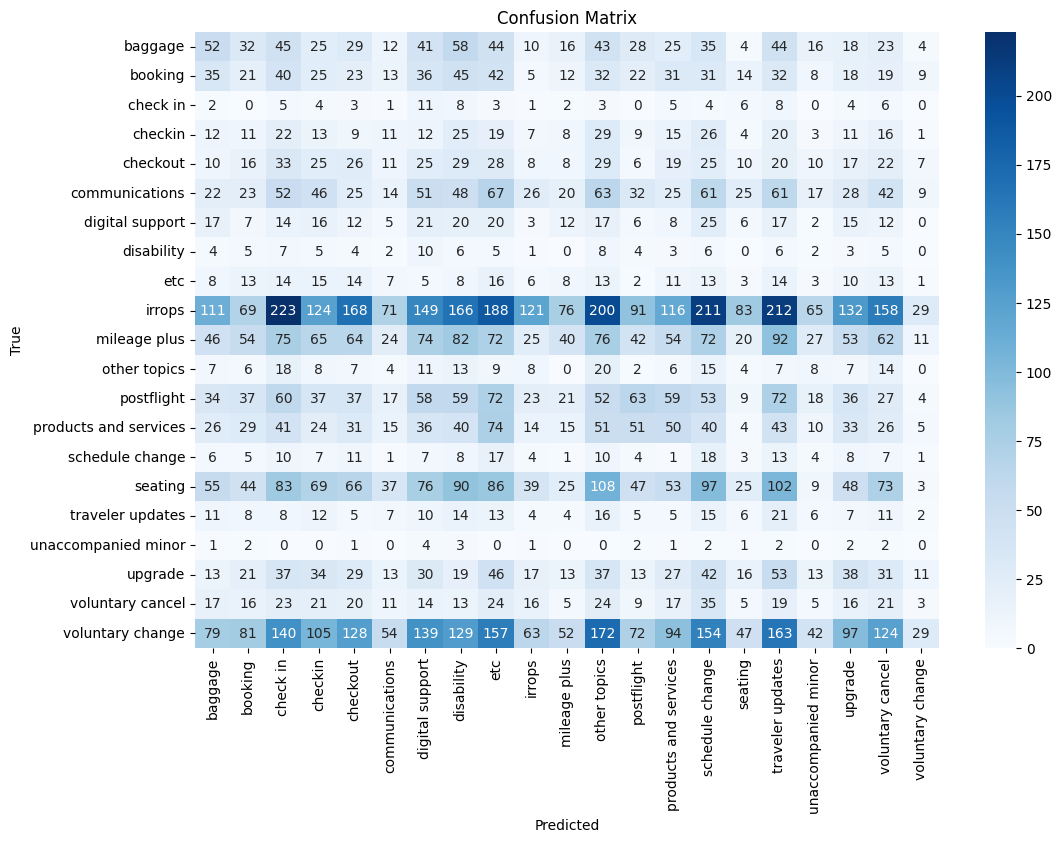

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Ensure you have a cleaned dataset ready as `X` and `y`

# Vectorizing the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(merged_data['clean_transcript'])

# Use a Random Forest Classifier
model = RandomForestClassifier()

# Define parameters for Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Grid Search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_tfidf, merged_data['clean_primary_call_reason'])

# Best model from Grid Search
best_model = grid_search.best_estimator_

# Predict and evaluate the model
y_pred = best_model.predict(X_test_tfidf)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
